# **Data Analyst Salary Trends: A Cluster Analysis of Technology Sector Compensation**

***Analyzing Salary Trends Across Various Technologies Using Generalized Additive Models (GAM)***

**Relevance to My Data Analytics Journey**

- As I transition into a career in data analytics, this project serves as both a learning experience and a portfolio piece that demonstrates my ability to work with real-world data, apply advanced statistical modeling, and extract actionable business insights. It aligns directly with my goal of developing strong data-driven decision-making skills while showcasing my ability to tackle complex analytical problems.

#### **Objective**

The primary objective of this project is to analyze salary trends in the data analytics job market and quantify how different technologies influence earnings over time. By leveraging Generalized Additive Models (GAM), the project seeks to:

- Understand Salary Evolution – Identify how the baseline salary trend (independent of technology) changes over time.
- Quantify the Impact of Technologies – Measure how specific technologies (SQL, Python, Power BI, etc.) affect salary levels and whether their influence is increasing or decreasing.
- Cluster Technologies Based on Salary Trends – Group technologies with similar salary patterns using clustering techniques to uncover broader industry trends.
- Support Career Decision-Making – Provide actionable insights for professionals, recruiters, and policymakers by highlighting which skills are most valuable in the job market.


### **0. Setup libraries and load data**

In [3]:
library(tidyverse) # metapackage of all tidyverse packages
library(mgcv) # for generalized additive models
library(lubridate)
library(cluster)

# load input data
df<-read_csv("gsearch_jobs.csv")

New names:
• `` -> `...1`
Rows: 60354 Columns: 27
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (16): title, company_name, location, via, description, extensions, job_...
dbl   (8): ...1, index, salary_avg, salary_min, salary_max, salary_hourly, s...
lgl   (2): work_from_home, commute_time
dttm  (1): date_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# cleanup data, remove columns that are not needed in this analysis
cdf<-df %>%
    dplyr::select(-`...1`,-`description`,-via,-thumbnail,-posted_at,-title,-extensions,-job_id) %>%
    mutate(description_tokens=str_replace_all(description_tokens,"[\'\\[\\] ]",""),date_time=date(date_time))%>%
    filter(!is.na(salary_hourly))%>%
    mutate(tokens=str_split(description_tokens,","))%>%
    select(-description_tokens)%>%
    unnest(tokens)%>%
    mutate(tokens=str_replace_all(tokens,"[[:punct:]]",""))%>%
    filter(tokens!="") %>%
    mutate(id=as.factor(index)) # create a fake index

### **1. Extracting and Manipulating data**

In [5]:
# extract keywords with at least 20 examples
top_k<-cdf %>% group_by(tokens) %>% summarise(n=n())%>%arrange(desc(n))%>%filter(n>20)
head(top_k)

tokens,n
<chr>,<int>
sql,1753
excel,1519
powerbi,1090
python,972
tableau,924
r,615


In [6]:
ucdf<-cdf%>%select(-tokens)%>%unique()
nrow(ucdf)

[1] 3630

In [7]:
# prepare dataset for running gam model
# pivot to wide format, with hot-encoding of tokens

cdf_wide <- cdf %>%
    filter(tokens %in% top_k$tokens)%>%
    group_by(id,tokens)%>%
    summarise(n=n(),.groups='drop')%>%
    transform(n=n>0)%>%
    pivot_wider(names_from = tokens,values_from = n,values_fill = F) %>%
    inner_join(ucdf, by="id") # add basic info, that was wiped by previous manipulations

In [8]:
head(cdf_wide)

id,excel,mysql,python,r,sas,spss,sql,tableau,word,⋯,search_location,commute_time,salary_pay,salary_rate,salary_avg,salary_min,salary_max,salary_hourly,salary_yearly,salary_standardized
<fct>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<chr>,<lgl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,United States,NA,40–200,an hour,120.00,40,200,120.00,NA,249600.0
2,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,United States,NA,40–200,an hour,120.00,40,200,120.00,NA,249600.0
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,⋯,United States,NA,16,an hour,16.00,NA,NA,16.00,NA,33280.0
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,⋯,United States,NA,21.01,an hour,21.01,NA,NA,21.01,NA,43700.8
6,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,⋯,United States,NA,17,an hour,17.00,NA,NA,17.00,NA,35360.0
7,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,⋯,United States,NA,20,an hour,20.00,NA,NA,20.00,NA,41600.0


In [9]:
nrow(cdf_wide)

[1] 3624

In [10]:
# perform clustering to tokengroups
dist_matrix <- dist(cdf_wide[top_k$tokens], method = "binary")

agnes_results <- cluster::agnes(
  dist_matrix, diss = TRUE, keep.diss = TRUE, method = "complete"
)

In [11]:
# finding optimal number of clusters by elbow method, measuring sum of squared differences
# idea from https://blog.tidy-intelligence.com/posts/clustering-binary-data/

compute_withinss<-function(k) {
dummy <- cdf_wide %>% select(top_k$tokens) %>% mutate(cluster=stats::cutree(agnes_results, k = k))

# calculate cluster mean
ctr<- dummy %>% group_by(cluster) %>% summarize(across(top_k$tokens, \(x) mean(x, na.rm = TRUE))) %>% pivot_longer(cols = -cluster, names_to = "token", values_to = "cluster_mean")

# calculate difference from mean
diff<- dummy %>% pivot_longer(cols = -cluster, names_to = "token", values_to = "value") %>% left_join(ctr,by=c('cluster','token')) %>%
    summarize(k = max(cluster), withinss = sum((value - cluster_mean)^2)) 

return(diff)
}

compute_withinss(3)

k,withinss
<int>,<dbl>
3,12094.48


In [12]:
compute_withinss(1)

k,withinss
<int>,<dbl>
1,12919.21


### **2. Elbow Method for Optimal Cluster Selection**

In [13]:
# compute log ratio between bl ( one cluster ) and given number
k_min=1
k_max=30

agnes_logwithindiss <- k_min:k_max %>%
  map(~compute_withinss(.)) %>%
  reduce(bind_rows)%>%
  mutate(logwithindiss = log(withinss) - log(withinss[k == 1]))

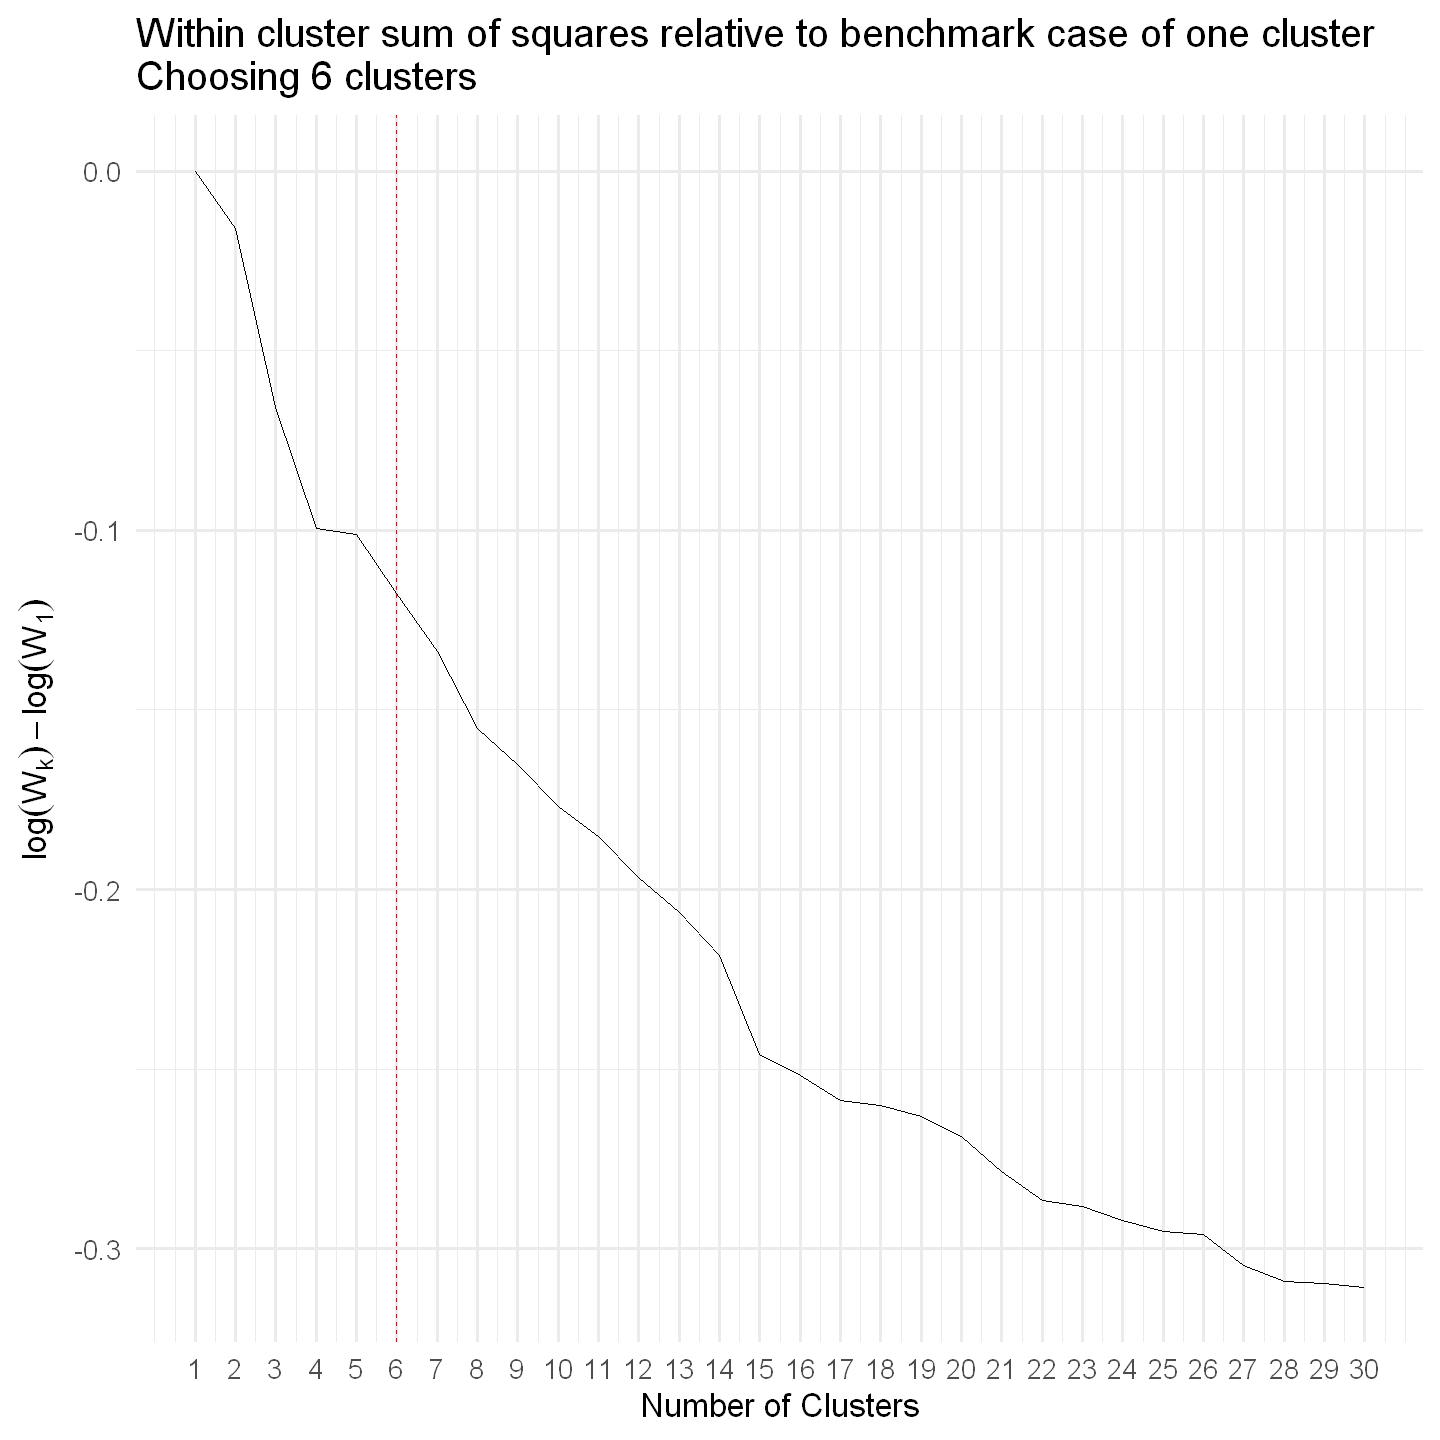

In [14]:
options(repr.plot.width=12, repr.plot.height=12)

agnes_logwithindiss%>%ggplot(aes(x = k, y = logwithindiss)) +
  theme_minimal(base_size=20) +
  geom_line() +
  scale_x_continuous(breaks = k_min:k_max) + 
  geom_vline(xintercept=6,col='red',lty=2)+
  labs(x = "Number of Clusters", y = bquote(log(W[k]) - log(W[1])), 
       title = "Within cluster sum of squares relative to benchmark case of one cluster\nChoosing 6 clusters")

### **3. Cluster Characterization and Visualization**

In [15]:
k=6 # using this nub
cluster_assignment <- stats::cutree(agnes_results, k = k)

# TODO: try elbow method to find optimal number of clusters
cdf_wide$cluster<-cluster_assignment

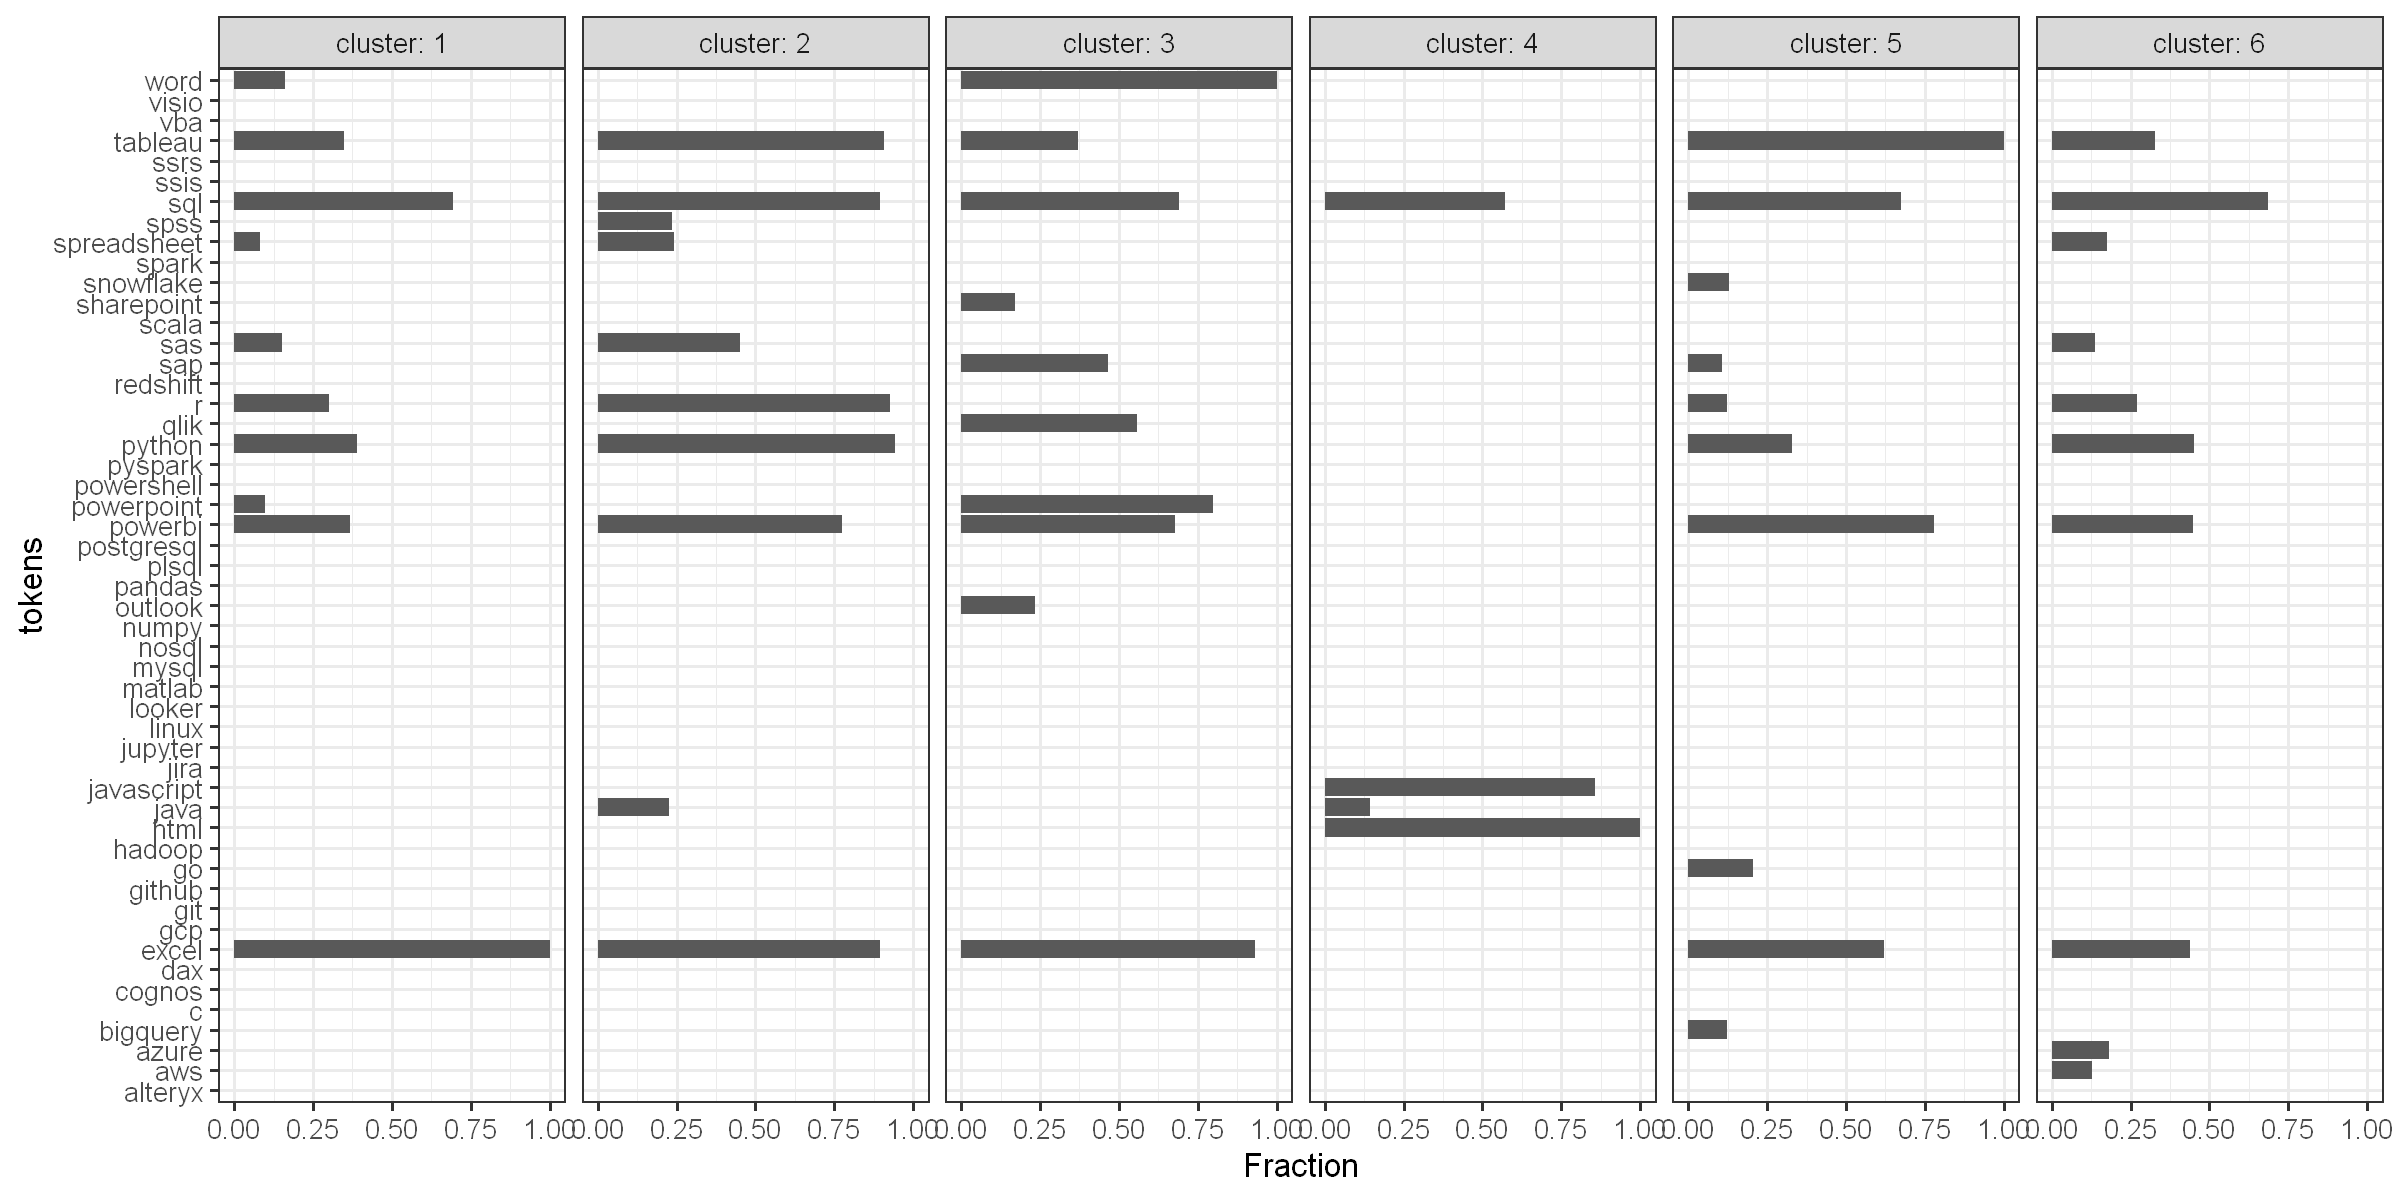

In [16]:
# show top 10 tokens for each cluster 
cluster_description_long<-cdf_wide %>% 
 group_by(cluster)%>%
 select(c(top_k$tokens,'cluster')) %>% 
 summarize_all(mean) %>% 
 pivot_longer(names_to='tokens',cols=top_k$tokens) %>% 
 mutate(tokens=as.factor(tokens)) %>%
 group_by(cluster) %>% 
 slice_max(value,n=10)
 
#cluster_description
options(repr.plot.width=20, repr.plot.height=10)

ggplot(cluster_description_long,aes(x=value,y=tokens))+
 theme_bw(base_size=20)+
 facet_wrap(~cluster,ncol=k,labeller = label_both)+
 geom_bar(stat="identity")+xlab("Fraction")
# geom_barplot()

In [17]:
# rename clusters to show tokens with more then 50% fraction for visualization only
cluster_names<- cdf_wide %>% 
    group_by(cluster)%>%
    select(c(top_k$tokens,'cluster')) %>% 
    summarize_all(mean) %>% 
    pivot_longer(names_to='tokens',cols=top_k$tokens) %>% 
    mutate(tokens=as.factor(tokens)) %>%
    group_by(cluster) %>% 
    filter(value>=0.5) %>% 
    group_by(cluster) %>% 
    mutate(cluster_nm = paste0(tokens, collapse = "_")) %>% 
    summarize(cluster_nm=first(cluster_nm)) %>%
    mutate(cluster_nm=as.factor(cluster_nm))

cluster_names

cluster,cluster_nm
<int>,<fct>
1,sql_excel
2,sql_excel_powerbi_python_tableau_r
3,sql_excel_powerbi_word_powerpoint_qlik
4,sql_javascript_html
5,sql_excel_powerbi_tableau
6,sql


In [18]:
# converting time to continious variables , counting from the earliest available post
start_date=min(cdf_wide$date_time)
end_date=max(cdf_wide$date_time)
t_span=as.numeric(end_date-start_date)

# remove individual tokens and add cluster names
cdf_wide<-cdf_wide %>% select(-one_of(top_k$tokens)) %>% 
    mutate(t=as.numeric(date_time-start_date)) %>% inner_join(cluster_names,by='cluster')

In [19]:
# convert cluster to one-hot encoding to simplify visualization after
cdf_swide<-cdf_wide%>% bind_cols(model.matrix(~0+cluster_nm,cdf_wide) %>% as.data.frame() %>% rename_all(function(x) stringr::str_replace_all(x, 'cluster_nm', '')))
head(cdf_swide)

id,index,company_name,location,schedule_type,work_from_home,salary,search_term,date_time,search_location,⋯,salary_standardized,cluster,t,cluster_nm,sql,sql_excel,sql_excel_powerbi_python_tableau_r,sql_excel_powerbi_tableau,sql_excel_powerbi_word_powerpoint_qlik,sql_javascript_html
<fct>,<dbl>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<date>,<chr>,⋯,<dbl>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,Upwork,Anywhere,Contractor and Temp work,TRUE,40–200 an hour,data analyst,2023-10-15,United States,⋯,249600.0,1,345,sql_excel,0,1,0,0,0,0
2,2,Upwork,Anywhere,Contractor and Temp work,TRUE,40–200 an hour,data analyst,2023-10-15,United States,⋯,249600.0,1,345,sql_excel,0,1,0,0,0,0
5,5,ACT,United States,Full-time,NA,16 an hour,data analyst,2023-07-22,United States,⋯,33280.0,2,260,sql_excel_powerbi_python_tableau_r,0,0,1,0,0,0
5,5,Sedgwick County,"Wichita, KS",Full-time,NA,21.01 an hour,data analyst,2023-01-08,United States,⋯,43700.8,2,65,sql_excel_powerbi_python_tableau_r,0,0,1,0,0,0
6,6,Select Source International,United States,Contractor,NA,17 an hour,data analyst,2023-06-06,United States,⋯,35360.0,1,214,sql_excel,0,1,0,0,0,0
7,7,Select Source International,United States,Contractor,NA,20 an hour,data analyst,2023-06-06,United States,⋯,41600.0,1,214,sql_excel,0,1,0,0,0,0


### **4. Generalized Additive Model (GAM) Fitting**

*Models salary trends over time while capturing non-linear patterns.*

In [21]:
# create a formula for GAM function , with smooth baseline function 
# and linear regression terms describing additive effect of each term on salary
fml<-as.formula(paste("salary_hourly~",paste0("(",paste(c(cluster_names$cluster_nm),collapse="+")),")*t+s(t)"))

model<-gam(fml, data=cdf_swide)

### **5. Analysis of Regression Results**

In [22]:
summary(model)


Family: gaussian 
Link function: identity 

Formula:
salary_hourly ~ (sql_excel + sql_excel_powerbi_python_tableau_r + 
    sql_excel_powerbi_word_powerpoint_qlik + sql_javascript_html + 
    sql_excel_powerbi_tableau + sql) * t + s(t)

Parametric coefficients:
                                           Estimate Std. Error t value Pr(>|t|)
(Intercept)                               1.543e+01  3.073e+00   5.022 5.37e-07
sql_excel                                 5.745e+00  3.873e+00   1.483   0.1381
sql_excel_powerbi_python_tableau_r        9.108e+00  3.990e+00   2.283   0.0225
sql_excel_powerbi_word_powerpoint_qlik    1.556e+00  4.434e+00   0.351   0.7257
sql_javascript_html                      -1.258e+01  1.927e+01  -0.653   0.5137
sql_excel_powerbi_tableau                 6.537e+00  4.138e+00   1.580   0.1143
sql                                       5.071e+00  3.784e+00   1.340   0.1803
t                                         6.565e-02  1.018e-02   6.450 1.27e-10
sql_excel:t      

### **6. Visualization of Regression Predictions and Confidence Intervals**

In [23]:
# visualize regression results,
# with poor-man's confidence intervals
sim<-expand.grid(
    t=seq(0,t_span,by=40),
    cluster_nm=c(levels(cluster_names$cluster_nm),"none")
) %>%
    mutate(n=1.0, id=row_number()) %>% 
    pivot_wider(names_from = cluster_nm, values_from = n, values_fill = 0.0)

sim_p<-predict(model,newdata=sim, se.fit=T)

# poor man's confidence intervals 1.96 should correspond roughly to 95% confidence intervals
sim<-bind_cols(sim,
               data.frame(
                   salary_hourly=sim_p$fit,
                   salary_hourly_low=sim_p$fit-1.96*sim_p$se.fit,
                   salary_hourly_high=sim_p$fit+1.96*sim_p$se.fit))


# show separate clusters
sim_longer<-sim %>% 
    pivot_longer(cols=c(levels(cluster_names$cluster_nm),"none"),names_to="cluster_nm",values_to="n")%>% filter(n==1.0)

# subtract baseline
sim_longer_bl<-sim_longer %>% 
    filter(cluster_nm=="none") %>% 
    select(-cluster_nm,-id,-n) %>% 
    rename(salary_hourly_bl=salary_hourly,
           salary_hourly_high_bl=salary_hourly_high,
           salary_hourly_low_bl=salary_hourly_low)

# calculate difference from the baseline for visualization purposes
sim_longer_diff<-inner_join( 
        sim_longer%>% select(-id,-n)%>% filter(cluster_nm!="none"),
        sim_longer_bl, by="t") %>% 
    mutate(salary_hourly=salary_hourly-salary_hourly_bl,
           salary_hourly_high=salary_hourly_high-salary_hourly_high_bl,
           salary_hourly_low=salary_hourly_low-salary_hourly_low_bl) %>% 
    select(-salary_hourly_bl,-salary_hourly_high_bl,-salary_hourly_low_bl)

# merge it all together and make names easier to read
sim_longer_diff_<- bind_rows(sim_longer_diff, sim_longer %>% filter(cluster_nm=="none") %>% mutate(cluster_nm='baseline')) %>%
    mutate(cluster=str_replace_all(cluster_nm,"_",","))

This step visualizes the regression results, highlighting the baseline smooth curve that represents overall salary trends over time. Additionally, it illustrates the linear effects of each technology, showing how different skill clusters influence salary variations.

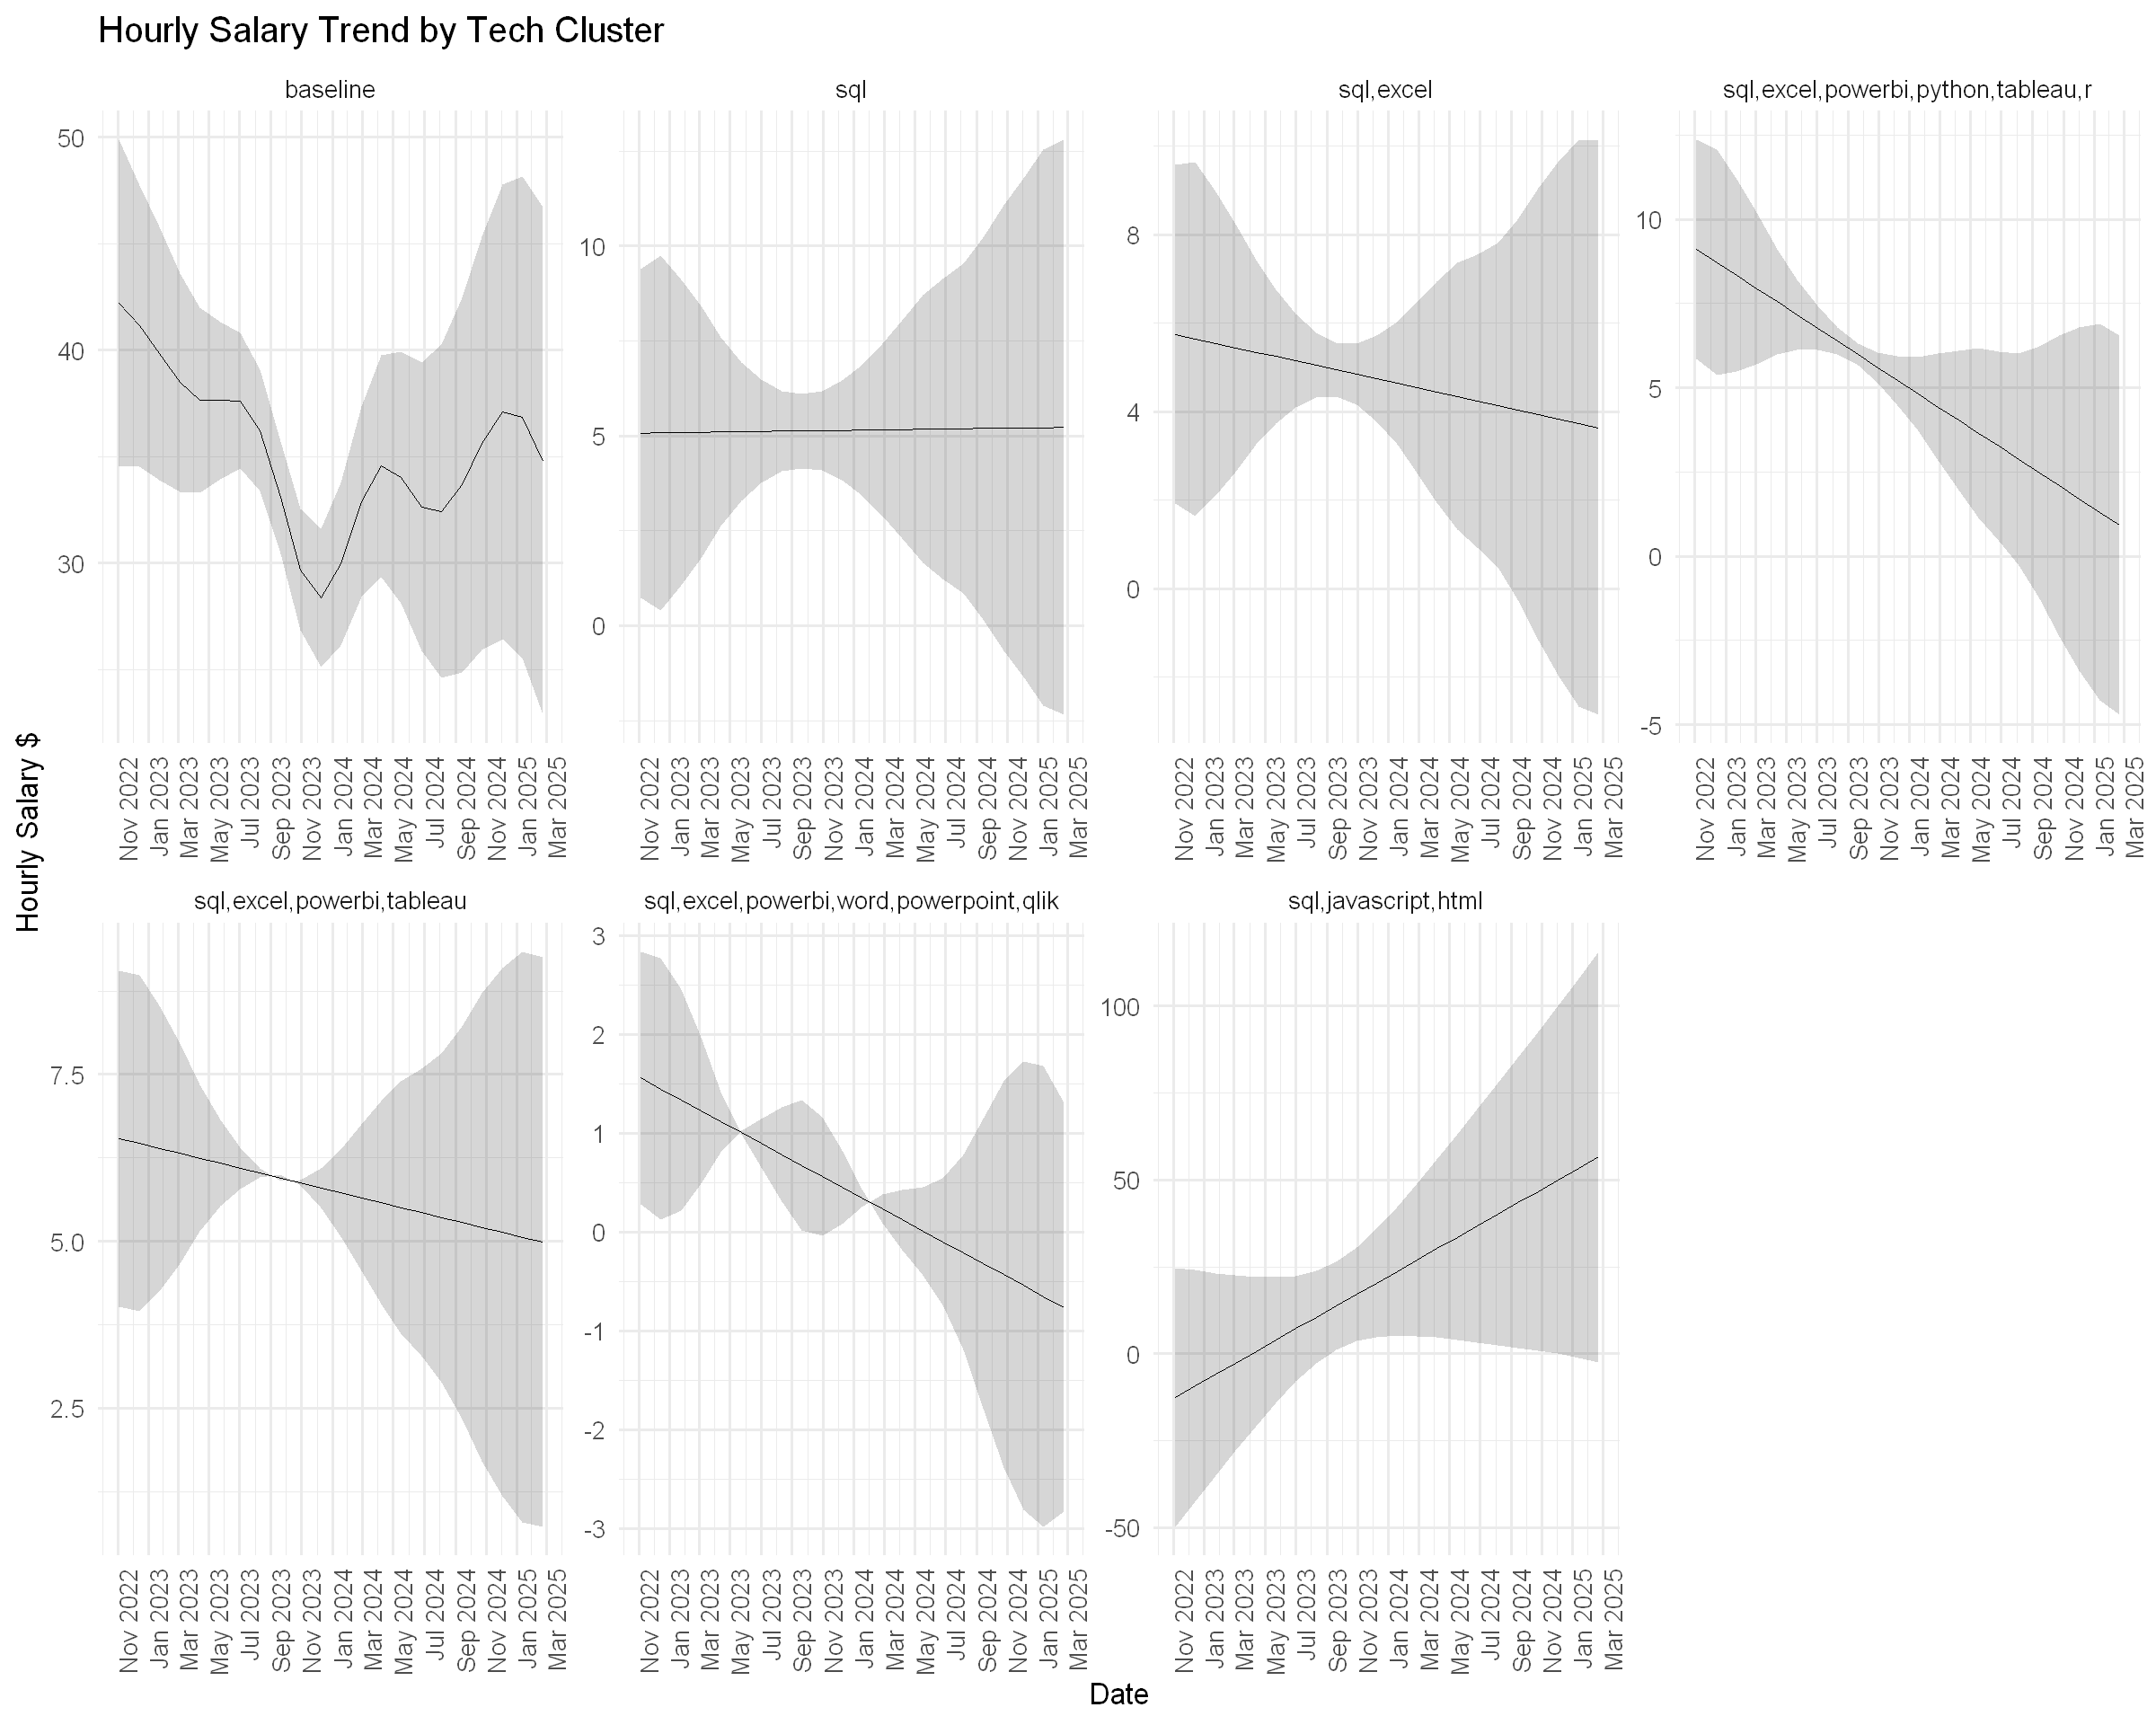

In [25]:
# plot effects
options(repr.plot.width=20, repr.plot.height=16)

ggplot(sim_longer_diff_, aes(x=start_date+days(t),y=salary_hourly))+
    geom_ribbon(aes(ymin=salary_hourly_low, ymax=salary_hourly_high),alpha=0.2)+
    geom_line()+
    facet_wrap(~cluster,scales='free',ncol=4)+
    labs(title="Hourly Salary Trend by Tech Cluster",
         x="Date",
         y="Hourly Salary $",
         color="Cluster",
         fill="Cluster")+
    scale_x_date(date_breaks = "2 months", date_labels =  "%b %Y")+
    theme_minimal(base_size = 20)+
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

### **7. Findings and Results**

##### 1. Overall Salary Trends (Baseline)
- The baseline salary trend shows fluctuations over time with noticeable dips and peaks.
- The uncertainty (confidence intervals) suggests market volatility affecting salary levels.
- A general downward trend is observed in some periods, indicating possible industry-wide salary reductions.

##### 2. SQL Cluster
- The salary trend for SQL-based roles follows a stable trajectory with some variations.
- The confidence intervals widen in certain periods, suggesting fluctuating demand for SQL-related skills.

##### 3. SQL + Excel Cluster
- SQL combined with Excel shows moderate salary stability but gradual declines over time.
- The trend might indicate saturation of SQL + Excel skills in the job market, reducing salary competitiveness.

##### 4. SQL + Excel + Power BI + Tableau Cluster
- Data analysts proficient in SQL, Excel, Power BI, and Tableau experience significant fluctuations in salary trends.
- The sharp dips suggest market saturation or evolving demand for alternative visualization tools.
- The salary uncertainty is high, meaning job roles with these skills might be unstable or highly competitive.

##### 5. SQL + Excel + Power BI + Word + PowerPoint + Qlik Cluster
- The trend line shows strong variations with unpredictable peaks and troughs.
- The volatility suggests either project-based compensation models or fluctuations in demand for a mix of these business intelligence tools.

##### 6. SQL + JavaScript + HTML Cluster
- This cluster has a strong upward trajectory, indicating increasing demand for analysts with SQL + JavaScript + HTML skills.
- This trend could be due to the rise in data-driven web applications and interactive dashboards.
- The growth pattern suggests long-term salary stability and potential salary increases in the future.

##### 7. Salary Growth and Decline Observations
- Tech stacks including web technologies (SQL + JavaScript + HTML) seem to be gaining value.
- Traditional data analytics tools (SQL + Excel + Power BI) are showing more fluctuations and possible salary declines.
- Broader skillsets with multiple tools introduce more volatility, possibly due to job role variations.

### **8. Business and Career Implications**
- SQL + Web Technologies (JavaScript, HTML) show strong future growth, making it a valuable upskilling area.
- Excel-heavy roles may be facing stagnation, suggesting a need to transition towards cloud-based analytics or programming-heavy roles.
- Data visualization tools (Power BI, Tableau, Qlik) show mixed trends, implying that having multiple tool proficiencies is essential but may not guarantee higher salaries.

### **9. Future Implications**
- **For Data Analysts:** Consider learning JavaScript and HTML for data visualization and dashboard-building skills.
- **For Employers:** Salary stabilization strategies are needed in traditional analytics roles to retain skilled talent.
- **For Industry Researchers:** Further analysis can explore regional differences, job role shifts, and demand surges in emerging tech clusters.


### **Conclusion**
SQL remains a valuable skill in data analytics; however, its impact on salary potential can be significantly enhanced by integrating web-based technologies such as JavaScript and HTML. The growing demand for interactive and real-time data visualization suggests that professionals with expertise in both SQL and web technologies may have a competitive edge in the job market. Meanwhile, traditional business intelligence tools, such as Power BI and Tableau, continue to be relevant but may require supplementary skills in coding and cloud-based solutions to remain competitive. As the industry evolves, adaptability and proficiency in emerging technologies will be key to sustaining career growth and maximizing earning potential.